
1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>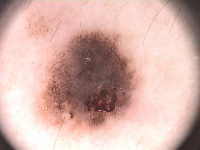</td><td>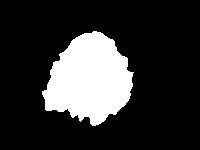</td></tr></table>

2. Разархивируем .rar файл.

Это фотографии двух типов **поражений кожи:** меланома и родинки.

In [ ]:
!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

--2024-02-19 15:02:34--  https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/8lqrloi0mxj2acu/PH2Dataset.rar [following]
--2024-02-19 15:02:34--  https://www.dropbox.com/s/raw/8lqrloi0mxj2acu/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca3bc9e2c6f2f29ab001dbac275.dl.dropboxusercontent.com/cd/0/inline/CNkvfUYLs3IrrINfCm6OFTccJpz51NCzGJ1E4TJRXVgBAQDF3tqP1FMCo23SpoDwXCtkN56sHgHauWwf4OjiYmur4noQ2kgbWws4Y2bPZW35-2QvedT_n1h1F3ePcpaorS4/file# [following]
--2024-02-19 15:02:36--  https://uca3bc9e2c6f2f29ab001dbac275.dl.dropboxusercontent.com/cd/0/inline/CNkvfUYLs3IrrINfCm6OFTccJpz51NCzGJ1E4TJRXVgBAQDF3tqP1FMCo23SpoDwXCtkN56sHgHauWwf4OjiYmur4noQ2kgbWws4Y2bPZW35-2Qved

In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Приводим их к размеру **256x256**

In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

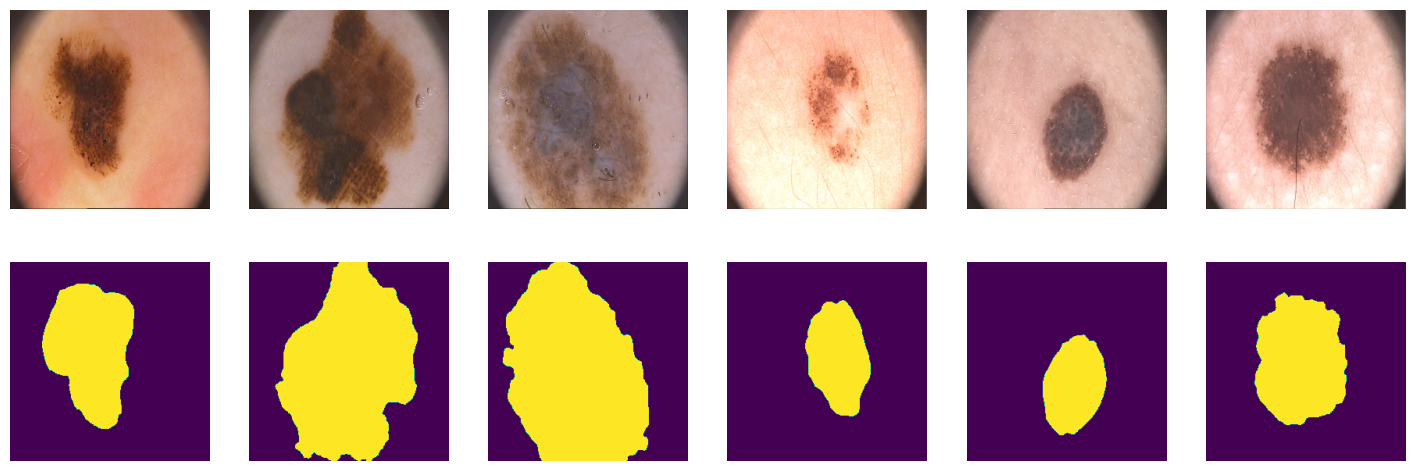

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
del X
del Y

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=device, abbreviated=False)
print(device)

cuda


# Реализация архитектуры:

-----------------------------------------------------------------------------------------

# SegNet

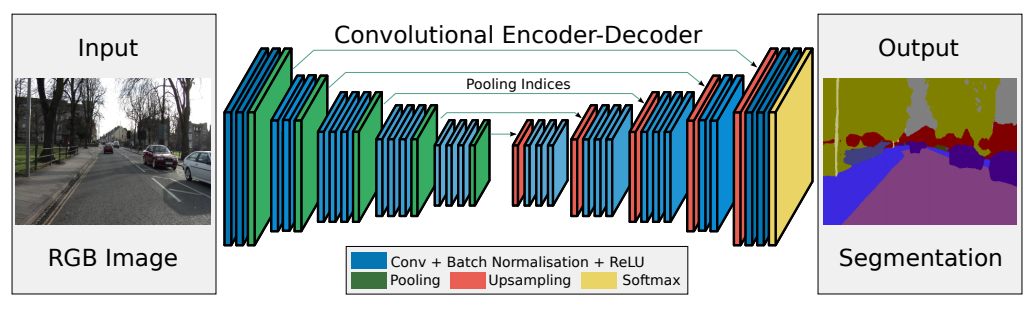

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
            )
        self.pool0 = nn.MaxPool2d(2,2,return_indices=True) # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
            )
        self.pool1 = nn.MaxPool2d(2,2,return_indices=True) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
            )
        self.pool2 = nn.MaxPool2d(2,2,return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
            )
        self.pool3 = nn.MaxPool2d(2,2,return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=1, padding=0, stride=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 512, kernel_size=1, padding=0, stride=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
            )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2,2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
            )
        self.upsample1 = nn.MaxUnpool2d(2,2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
            )
        self.upsample2 = nn.MaxUnpool2d(2,2) # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
            )
        self.upsample3 = nn.MaxUnpool2d(2,2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(1),
            nn.ReLU(inplace=True),
            nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
            )

    def forward(self, x):
        # encoder
        e0,ind = self.pool0(self.enc_conv0(x))
        e1,ind1 = self.pool1(self.enc_conv1(e0))
        e2,ind2 = self.pool2(self.enc_conv2(e1))
        e3,ind3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.upsample0(b,ind3))
        d1 = self.dec_conv1(self.upsample1(d0,ind2))
        d2 = self.dec_conv2(self.upsample2(d1,ind1))
        d3 = self.dec_conv3(self.upsample3(d2,ind)) # no activation
        return d3

## Метрика

В проекте изпользуется следующая метрика для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    labels = labels.byte()
    outputs = (outputs > 0.5).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))
    union = (outputs | labels).float().sum((1, 2))

    iou = (intersection + SMOOTH) / (union + SMOOTH)

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10

    return thresholded

## Функция потерь

In [ ]:
def bce_loss(y_real, y_pred):
    # TODO
    return torch.mean(y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred)))
    # please don't use nn.BCELoss. write it from scratch

In [ ]:
class diceloss(torch.nn.Module):
    def init(self):
        super(diceloss, self).init()
    def forward(self,pred, target):
       smooth = 1.
       iflat = pred.contiguous().view(-1)
       tflat = target.contiguous().view(-1)
       intersection = (iflat * tflat).sum()
       A_sum = torch.sum(iflat * iflat)
       B_sum = torch.sum(tflat * tflat)
       return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth))

## Тренировка

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()
        for X_batch, Y_batch in data_tr:

            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            opt.zero_grad()

            Y_pred = model(X_batch)

            loss = loss_fn(Y_batch, Y_pred)
            loss.backward()
            opt.step()


            avg_loss += loss / len(data_tr)
        toc = time()

        model.eval()


        Y_hat = (model(X_val.to(device)).to("cpu").detach()) > 0.5
        X_hat = Y_val.to("cpu").detach()

        clear_output(wait=True)
        clear_output(wait=True)

        for k in range(6):
            plt.subplot(3, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')

        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
        print('loss:', avg_loss, toc - tic)

## Инференс

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.to(device))
        scores += metric(Y_pred.to("cpu"), Y_label.to("cpu")).mean().item()

    return scores/len(data)

## Обучение


Проводим тестирование:

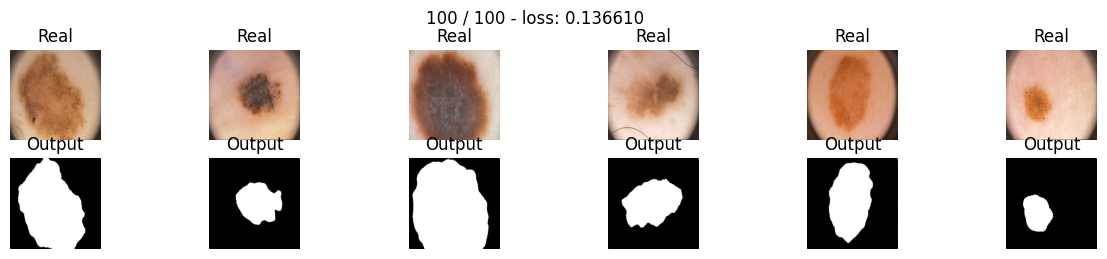

loss: tensor(0.1366, device='cuda:0', grad_fn=<AddBackward0>) 0.762808084487915


In [ ]:
model_segnet = SegNet().to(device)

max_epochs = 100
optimaizer = torch.optim.Adam(model_segnet.parameters(), lr=1e-4, amsgrad=True)
criterion = diceloss()
train(model_segnet, optimaizer, criterion, max_epochs, data_tr, data_val)

In [ ]:
score_model(model_segnet, iou_pytorch, data_val)

0.8157734572887421

In [ ]:
torch.save(model_segnet, 'model_segmentation')

# Prediction

Test_images


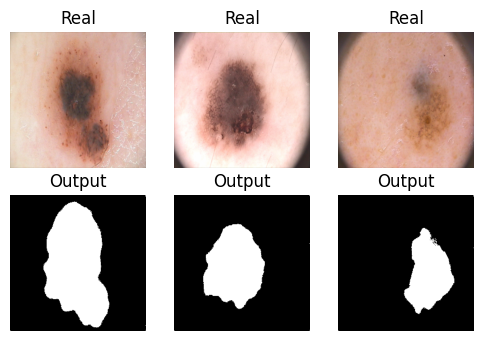

In [129]:
import os
from skimage.transform import resize
from torch.utils.data import DataLoader
from skimage.io import imread
import torch
import numpy as np
from torchvision.utils import save_image
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load('model_segmentation', map_location=device)

directory = input()
files = []
files += os.listdir(directory)

images_prediction = []
lesions_prediction = []

for path in files:
    if path != '.ipynb_checkpoints':
        images_prediction.append(imread(os.path.join(directory, path)))
        lesions_prediction.append(None)

size = (256, 256)
X_prediction = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images_prediction]
Y_prediction = [y for y in lesions_prediction]

X_prediction = np.array(X_prediction, np.float32)
Y_prediction = np.array(Y_prediction, np.float32)

batch_size = len(X_prediction)
tr = [i for i in range(len(X_prediction))]
data_tr_prediction = DataLoader(list(np.rollaxis(X_prediction[tr], 3, 1)),
                     batch_size=batch_size, shuffle=True)

model.eval()
pred_list = []
for i in data_tr_prediction:
    i = i.to(device)
    y_pred_prediction = (model(i).to("cpu").detach()) > 0.5
    pred_list.append(y_pred_prediction)
    i = i.to('cpu')
    for k in range(3):
            plt.subplot(3, 3, k+1)
            plt.imshow(np.rollaxis(i[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 3, k+4)
            plt.imshow(y_pred_prediction[k, 0], cmap='gray')
            save_image(y_pred_prediction[k, 0].float(), f"output/Tets{k+1}.png")
            plt.title('Output')
            plt.axis('off')